### Individual Assignnment

### Adam Patula

### Andrew ID: APATULA

Import Necessary Libraries and Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime, timedelta

#### Import Datasets

Yahoo Finance Historical GameStop Stock Price Data

In [2]:
# GME Stock Data 04JAN-31DEC21 URL: https://finance.yahoo.com/quote/GME/history?period1=1609718400&period2=1640908800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

df_stock = pd.read_csv("GME.csv")

In [3]:
#convert date to datetime object
df_stock['Date'] = pd.to_datetime(df_stock['Date'])

EDA for Yaho Finance Data

In [4]:
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,4.7500,4.7750,4.2875,4.3125,4.3125,40090000
1,2021-01-05,4.3375,4.5200,4.3075,4.3425,4.3425,19846000
2,2021-01-06,4.3350,4.7450,4.3325,4.5900,4.5900,24224800
3,2021-01-07,4.6175,4.8625,4.5050,4.5200,4.5200,24517200
4,2021-01-08,4.5450,4.5750,4.2700,4.4225,4.4225,25928000


In [5]:
df_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [6]:
df_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02
mean,42.761091,45.461538,40.083353,42.426686,42.426686,5.732827e+07
std,14.877450,16.198366,13.652308,14.391762,14.391762,1.138750e+08
min,4.335000,4.520000,4.270000,4.312500,4.312500,3.272800e+06
25%,38.930625,40.059375,36.928750,38.792500,38.792500,8.615300e+06
50%,44.261252,46.209999,42.885000,44.508751,44.508751,1.706600e+07
75%,50.973750,53.127501,48.940624,50.692500,50.692500,4.798740e+07
max,94.927498,120.750000,72.877502,86.877502,86.877502,7.886316e+08


Reddit Dataset on Meme Stock: GameStop

Han, Jing, 2022, "Reddit Dataset on Meme Stock: GameStop", https://doi.org/10.7910/DVN/TUMIPC, Harvard Dataverse, V3, UNF:6:c9s1zhZLHH+k32UmoPZu7A== [fileUNF]

Subset used: rGME_dataset_features

In [7]:
df_rGME = pd.read_csv('rGME_dataset_features.csv', index_col=0)

C:\Users\patul\AppData\Local\Temp\ipykernel_4320\1996247414.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_rGME = pd.read_csv('rGME_dataset_features.csv', index_col=0)


In [8]:
df_rGME

,id,title,url,score,author,num_comments,date,flair,compound,neg,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
0,kqfajb,You NEED to see this about GME 🚀🚀🚀🚀🚀🚀,https://www.reddit.com/r/GME/comments/kqfajb/y...,1.0,TitsDownOnly,9.0,2021-01-04,NaN,0.9872,0.000,...,0,0,6,0,0,0,0,0,0,0
1,kqjh2t,Short Squeeze Incoming 🚀🚀🚀🚀🚀🚀🚀,/r/wallstreetbets/comments/kqcwdo/gamestops_gr...,1.0,zoomermoney,1.0,2021-01-04,NaN,0.9906,0.000,...,0,0,3,0,0,0,0,0,0,0
2,kqvp7l,THIS CONVINCED ME TO ALL IN 💰GME (EXTREME PUMP...,https://www.reddit.com/r/GME/comments/kqvp7l/t...,1.0,TitsDownOnly,6.0,2021-01-05,NaN,0.5319,0.000,...,0,0,0,0,0,0,0,0,0,0
3,krcwch,You already know what we must do brothers and ...,/r/wallstreetbets/comments/kr98ym/gme_gang_we_...,1.0,dontforgettolive,4.0,2021-01-05,NaN,-0.2960,0.115,...,1,0,0,0,0,0,0,0,0,0
4,krnthg,ICR conference (11th Jan),https://www.reddit.com/r/GME/comments/krnthg/i...,1.0,nicky94,10.0,2021-01-06,NaN,0.0000,0.000,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033231,rta681,Hedgies are relics of past generations- they h...,https://www.reddit.com/r/GME/comments/rta681/h...,1.0,tensoranalysis,0.0,2021-12-31,☁️ Fluff 🍌,-0.2960,0.128,...,1,0,0,0,0,0,0,0,0,0
1033232,rtadde,Snapchat on 🔥🔥🔥,https://i.redd.it/vkh6v7wyvz881.jpg,1.0,Starmeister1,0.0,2021-12-31,📱 Social Media 🐦,-0.7351,0.783,...,0,0,0,0,0,0,0,0,0,1
1033233,rtaido,MOASS has ruined me this year. But I will stil...,https://www.reddit.com/r/GME/comments/rtaido/m...,1.0,DesinaDowns,0.0,2021-12-31,☁️ Fluff 🍌,-0.3274,0.190,...,0,0,0,1,0,0,0,0,0,0
1033234,rtb4nb,Patterns for 2022???,https://www.reddit.com/r/GME/comments/rtb4nb/p...,1.0,tdewault95,0.0,2021-12-31,🐵 Discussion 💬,0.0000,0.000,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_rGME.columns

Index(['id', 'title', 'url', 'score', 'author', 'num_comments', 'date',
       'flair', 'compound', 'neg', 'neu', 'pos', 'spacy_title', 'clean_text',
       'char_count', 'word_count', 'word_count_cln', 'stopword_count',
       'pos_tags', 'dep_tags', '_NOUN', '_VERB', '_ADP', '_ADJ', '_DET',
       '_PROPN', '_INTJ', '_PUNCT', '_NUM', '_PRON', '_ADV', '_PART', '_amod',
       '_ROOT', '_punct', '_advmod', '_auxpass', '_nsubjpass', '_ccomp',
       '_acomp', '_neg', '_nsubj', '_aux', '_agent', '_det', '_pobj', '_prep',
       '_csubj', '_nummod', '_attr', '_acl', '_relcl', '_dobj', '_pcomp',
       '_xcomp', '_cc', '_conj', '_mark', '_prt', '_compound', '_dep',
       '_advcl', '_parataxis', '_poss', '_intj', '_appos', '_npadvmod',
       '_predet', '_case', '_expl', '_oprd', '_dative', '_nmod'],
      dtype='object')

In [10]:
df_rGME.describe()

,score,num_comments,compound,neg,neu,pos,char_count,word_count,word_count_cln,stopword_count,...,_poss,_intj,_appos,_npadvmod,_predet,_case,_expl,_oprd,_dative,_nmod
count,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,...,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06,1.033236e+06
mean,3.486193e+00,1.226942e+01,1.522685e-01,6.738097e-02,7.934561e-01,1.391690e-01,6.430340e+01,1.445187e+01,6.717018e+00,5.965602e+00,...,2.562241e-01,3.902497e-02,1.717391e-01,1.465261e-01,2.496235e-02,3.924273e-02,6.202842e-03,4.940788e-03,1.413811e-02,1.451914e-01
std,9.373280e+01,1.075906e+02,4.197483e-01,1.477525e-01,2.366692e-01,2.072161e-01,5.905740e+01,1.314803e+01,5.758246e+00,6.800317e+00,...,5.142755e-01,2.188352e-01,7.734972e-01,4.274982e-01,1.573509e-01,2.008172e-01,8.162009e-02,8.132627e-02,1.214386e-01,9.251204e-01
min,0.000000e+00,0.000000e+00,-9.963000e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.520000e-01,0.000000e+00,2.600000e+01,6.000000e+00,3.000000e+00,2.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,8.520000e-01,0.000000e+00,4.500000e+01,1.000000e+01,5.000000e+00,4.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+01,4.574000e-01,5.900000e-02,1.000000e+00,2.310000e-01,7.700000e+01,1.700000e+01,9.000000e+00,8.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.957800e+04,3.618900e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.210000e+02,1.590000e+02,1.590000e+02,5.100000e+01,...,9.000000e+00,1.900000e+01,1.470000e+02,5.800000e+01,3.000000e+00,2.000000e+01,3.000000e+00,1.100000e+01,4.000000e+00,1.480000e+02


#### TDM Studio Sentiment Analysis 04JAN-31DEC21

##### Source: https://tdmstudio.proquest.com/analysis/viz/sa/apatulaandrewcmuedu-GameStop04JAN-31DEC21-1707689470601

TDM Studio GameStop Sentiment Analysis Data: ProQuest TDM Studio is a text and data mining research tool at https://tdmstudio.proquest.com/, access for which can be provided through the CMU Library. This tool was used to search for mentions of "GameStop" and related fields in 1051 newspapers, interviews, editorials, dissertations, theses, and journals available in the ProQuest database from 17 different sources (e.g., The Times of India, New York Times, Washington Post, etc.). TDM Studio uses its own, BERT-based model to determine an emotion assignment for each sentence of an article in the search space. These probabilities are then averaged at the document level and then average again for all documents in a specific date range (January 4, 2021 to December 31, 2021 to collect any relevant data).

The resultant dataset contains 10 columns and 51 rows indexed by week, year and month with 9 distinct emotion attributes assigned to the documents within that timeframe:

1. Anger
2. Disgust
3. Fear
4. Sadnes
5. Happiness
6. Love
7. Surprise
8. Neutral
9. Other

Each data point is then an averaged affect probability for each of the nine classes indicating the likelihood that a document in one of the available date ranges is assigned to a specific emotion.

In [11]:
df_TDM = pd.read_csv('emotion_time.csv')

In [12]:
df_TDM.head()

,Date Range,Anger,Disgust,Fear,Sadness,Happiness,Love,Surprise,Neutral,Other
0,2021-01-11/2021-01-17,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174
1,2021-01-18/2021-01-24,0.080808,0.066206,0.085939,0.148403,0.154426,0.023851,0.190875,0.181870,0.067623
2,2021-01-25/2021-01-31,0.118919,0.086057,0.070727,0.093651,0.128504,0.031275,0.237286,0.161021,0.072560
3,2021-02-01/2021-02-07,0.109803,0.090097,0.066075,0.086506,0.137711,0.032282,0.224728,0.175876,0.076922
4,2021-02-08/2021-02-14,0.099007,0.091747,0.063766,0.079963,0.147129,0.036771,0.219848,0.181026,0.080744


In [13]:
len(df_TDM)   

51

In [14]:
def create_date_ranges(row):
    '''
    This function takes a row in a dataframe as an input where the first row is a string of the form: 021-01-11/2021-01-17
    This encompasses a week, which is split.
    A list of all the days within the range is then returned.
    **See code generated by ChatGPT for assistance in Appendix A
    '''
    # split date range
    start, end = row['Date Range'].split('/')
    # get start
    start = datetime.strptime(start, "%Y-%m-%d")
    # get end
    end = datetime.strptime(end, "%Y-%m-%d")
    # get dates in between
    date_range = [start + timedelta(days=x) for x in range(0, (end-start).days +1)]
    return date_range

In [15]:
def create_data_by_day(df):
    '''
    TDM Studio Sentiment Analysis tool conducted analysis on a weekly basis for the selected date range. This function
    is designed to create a new dataframe that takes the weekly sentiment values and assigns them to all of the days
    during a given week for simplicity. This does not follow what actually occurred in terms of document publication
    during the weeks in question.
    '''
    
    df_emotions = df.drop(['Date Range'], axis=1)
    length = len(df)
    day_list = []
    # Source: https://www.geeksforgeeks.org/how-to-add-one-row-in-an-existing-pandas-dataframe/
    for n in range(0, length):
        # get individual row
        row = df.iloc[n]
        #get date range
        date_range = create_date_ranges(row)
        # create a new row for each date, but add each week's sentiment seven times
        for date in date_range:
            new_row = {col: row[col] for col in df_emotions.columns}
            new_row['Date'] = date
            day_list.append(new_row)
    
    df_daily = pd.DataFrame(day_list)
    return df_daily
            

In [16]:
df_TDM_daily = create_data_by_day(df_TDM)
df_TDM_daily.head()

,Anger,Disgust,Fear,Sadness,Happiness,Love,Surprise,Neutral,Other,Date
0,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-11
1,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-12
2,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-13
3,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-14
4,0.064095,0.064161,0.039228,0.072372,0.172943,0.032801,0.278547,0.204678,0.071174,2021-01-15


In [17]:
# create melted emotion dataframe for EDA
data_melt = df_TDM_daily.melt(
    id_vars=['Date'],
    value_vars=['Anger', 'Disgust','Fear', 'Sadness', 'Happiness', 'Love', 'Surprise', 'Neutral', 'Other'],
    value_name='emotion_score',
    var_name='Emotion'
)
data_melt.head()

,Date,Emotion,emotion_score
0,2021-01-11,Anger,0.064095
1,2021-01-12,Anger,0.064095
2,2021-01-13,Anger,0.064095
3,2021-01-14,Anger,0.064095
4,2021-01-15,Anger,0.064095


#### Visualizing TDM Studio Sentiment

In [18]:
# chart with all Sentiment Scores
chart_TDM_GME_sentiment = alt.Chart(data_melt).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    y='emotion_score:Q',
    color='Emotion:N',
    tooltip=['Date:T', 'Emotion:N','emotion_score:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_TDM_GME_sentiment

alt.Chart(...)

In [19]:
#chart with only Anger, Fear, Happiness, and Surprise
# create melted emotion dataframe for EDA
data_melt_select = df_TDM_daily.melt(
    id_vars=['Date'],
    value_vars=['Anger', 'Fear', 'Happiness', 'Surprise'],
    value_name='emotion_score',
    var_name='Emotion'
)
data_melt_select.head()

,Date,Emotion,emotion_score
0,2021-01-11,Anger,0.064095
1,2021-01-12,Anger,0.064095
2,2021-01-13,Anger,0.064095
3,2021-01-14,Anger,0.064095
4,2021-01-15,Anger,0.064095


In [20]:
# chart with select Sentiment Scores
chart_TDM_GME_sentiment = alt.Chart(data_melt_select).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    y='emotion_score:Q',
    color='Emotion:N',
    tooltip=['Date:T', 'Emotion:N','emotion_score:Q']
).properties(
    width=800,
    height=400,
    title="Sentiment Trends over Time"
).interactive()
chart_TDM_GME_sentiment

alt.Chart(...)

#### Visualizing Closing Prices

In [21]:
chart_GME_closing = alt.Chart(df_stock).mark_line().encode(
    x=alt.X('Date:T', axis=alt.Axis(titleFontSize=16)),
    y=alt.Y("Close:Q", axis=alt.Axis(titleFontSize=16)).title("Closing Price ($)"),
    #Source: https://altair-viz.github.io/gallery/scatter_tooltips.html
    tooltip=['Date', 'Close']
).properties(
    width=800,
    height=400,
    title='GME Closing Prices (04JAN-31DEC21)'
).configure_title(
    fontSize=24
).configure_axis(
    labelFontSize=16
).interactive()
chart_GME_closing

alt.Chart(...)

In [22]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df_stock['Close'].values.reshape(-1,1))

In [24]:
# Function to create sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length):
        x = data[i:(i + sequence_length)]
        y = data[i + sequence_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [25]:
SEQUENCE_LENGTH = 30  # You can adjust this value -> parameter tuning
X, y = create_sequences(scaled_data, SEQUENCE_LENGTH)

In [26]:
print(X.shape)
print(y.shape)

(222, 30, 1)
(222, 1)


In [27]:
# Split into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [30]:
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20

6/6 [==============================] - 2s 9ms/step - loss: 0.1663
Epoch 2/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0276
Epoch 3/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0162
Epoch 4/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 5/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0113
Epoch 6/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0122
Epoch 7/20
6/6 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 8/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 9/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0096
Epoch 10/20
6/6 [==============================] - 0s 7ms/step - loss: 0.0096
Epoch 11/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0094
Epoch 12/20
6/6 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 13/20
6/6 [==============================] - 0s 9ms/step - loss: 0

In [31]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
#predicted_prices

2/2 [==============================] - 0s 19ms/step


In [32]:
# Assuming `scaler` is your MinMaxScaler instance used to scale the 'Close' prices
# And assuming `predicted_prices` are your model's predictions

# Scale back the predictions
predicted_prices_original = scaler.inverse_transform(predicted_prices)

# If you also scaled `y_test`, you need to scale it back as well
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# Now `predicted_prices_original` and `y_test_original` are in the original price range



In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_original, predicted_prices)
mse = mean_squared_error(y_test_original, predicted_prices)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 4.035902273209635
MSE: 23.510456771811107
RMSE: 4.848758271125826


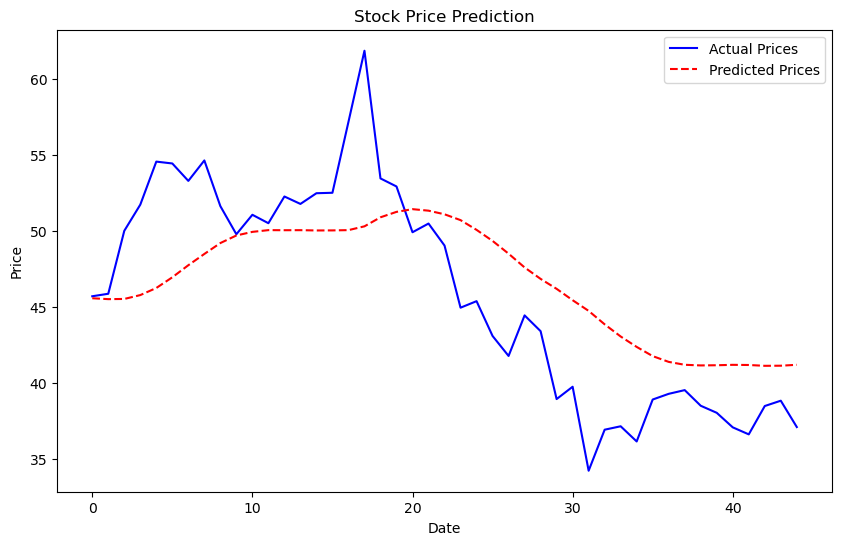

In [34]:
import matplotlib.pyplot as plt

# Assuming `y_test` and `predicted_prices` are scaled back to the original price range
plt.figure(figsize=(10,6))
plt.plot(y_test_original, color='blue', label='Actual Prices')
plt.plot(predicted_prices, color='red', linestyle='--', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


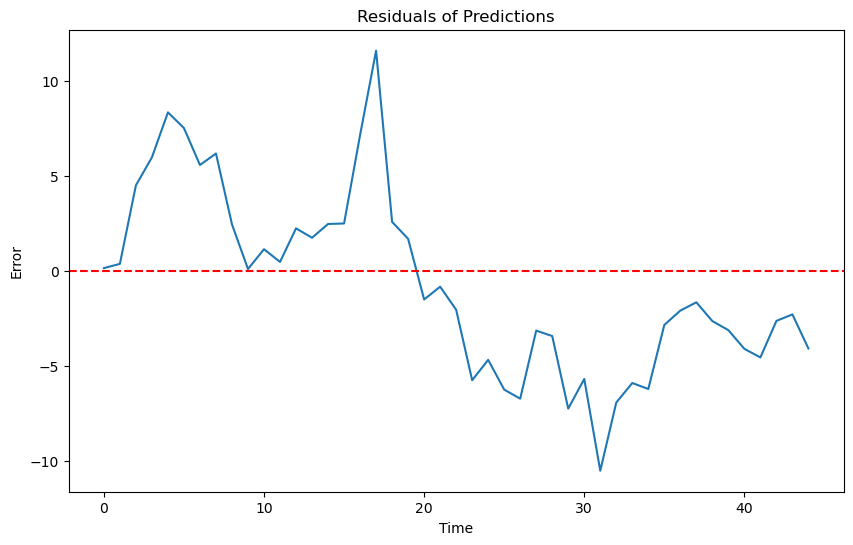

In [35]:
residuals = y_test_original - predicted_prices

plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


In [36]:
#rolling average feature
df_stock['7 Day Rolling Avg'] = df_stock['Close'].rolling(window=7).mean()

In [37]:
df_stock['7 Day Rolling Avg'].fillna(method='bfill', inplace=True)

In [38]:
column_to_move = df_stock.pop('Close')

In [39]:
column_to_move

0       4.312500
1       4.342500
2       4.590000
3       4.520000
4       4.422500
         ...    
247    37.077499
248    36.615002
249    38.482498
250    38.832500
251    37.097500
Name: Close, Length: 252, dtype: float64

In [40]:
df_stock.columns

Index(['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume',
       '7 Day Rolling Avg'],
      dtype='object')

In [41]:
df_stock.insert(0, "Close", column_to_move)

In [43]:
features = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', '7 Day Rolling Avg']
features = df_stock[features].values

In [44]:
scaler2 = MinMaxScaler(feature_range=(0,1))
scaled_data2 = scaler2.fit_transform(features)

In [45]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])  # All features except the target variable
        y.append(data[i + sequence_length, -1])  # Target variable (e.g., Close price)
    return np.array(X), np.array(y)

In [46]:
sequence_length = 60  # Example sequence length
X, y = create_sequences(scaled_data2, sequence_length)

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
model2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(60,6)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

In [49]:
print(X.shape)
print(y.shape)

(192, 60, 6)
(192,)


In [50]:
model2.compile(optimizer='adam', loss='mean_squared_error')

In [51]:
model2.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
5/5 [==============================] - 2s 19ms/step - loss: 0.1626
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0400
Epoch 3/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0113
Epoch 4/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0160
Epoch 5/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0050
Epoch 6/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0079
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0045
Epoch 8/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0053
Epoch 9/20
5/5 [==============================] - 0s 16ms/step - loss: 0.0039
Epoch 10/20
5/5 [==============================] - 0s 15ms/step - loss: 0.0039
Epoch 11/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0034
Epoch 12/20
5/5 [==============================] - 0s 17ms/step - loss: 0.0035
Epoch 13/20
5/5 [==============================] - 0s 16ms/st

In [52]:
predicted_prices2 = model2.predict(X_test)
predicted_prices2 = scaler.inverse_transform(predicted_prices2)
#predicted_prices


2/2 [==============================] - 0s 10ms/step


In [53]:
# Assuming `scaler` is your MinMaxScaler instance used to scale the 'Close' prices
# And assuming `predicted_prices` are your model's predictions

# Scale back the predictions
predicted_prices_original2 = scaler.inverse_transform(predicted_prices2)

# If you also scaled `y_test`, you need to scale it back as well
y_test_original2 = scaler.inverse_transform(y_test.reshape(-1, 1))

# Now `predicted_prices_original` and `y_test_original` are in the original price range



In [54]:
mae = mean_absolute_error(y_test_original2, predicted_prices2)
mse = mean_squared_error(y_test_original2, predicted_prices2)
rmse = np.sqrt(mse)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')


MAE: 1.8106489101356567
MSE: 7.461305251345729
RMSE: 2.7315389895342386


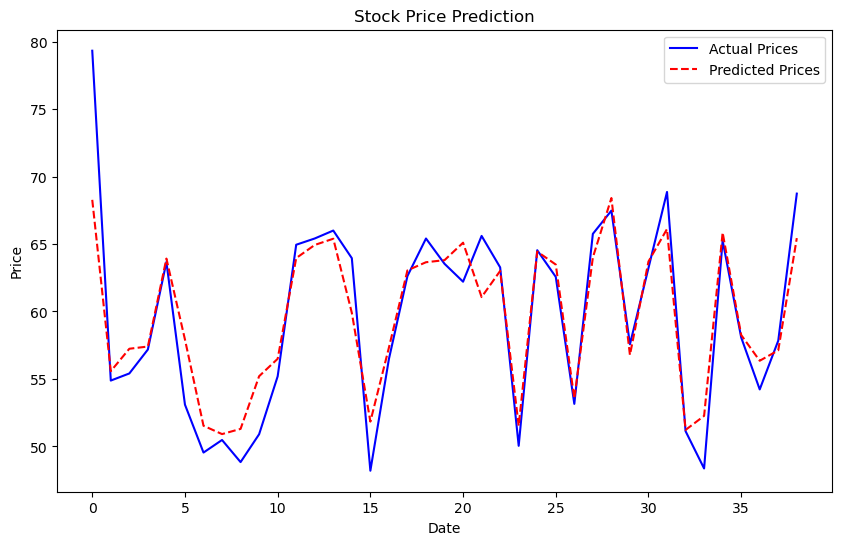

In [55]:
import matplotlib.pyplot as plt

# Assuming `y_test` and `predicted_prices` are scaled back to the original price range
plt.figure(figsize=(10,6))
plt.plot(y_test_original2, color='blue', label='Actual Prices')
plt.plot(predicted_prices2, color='red', linestyle='--', label='Predicted Prices')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


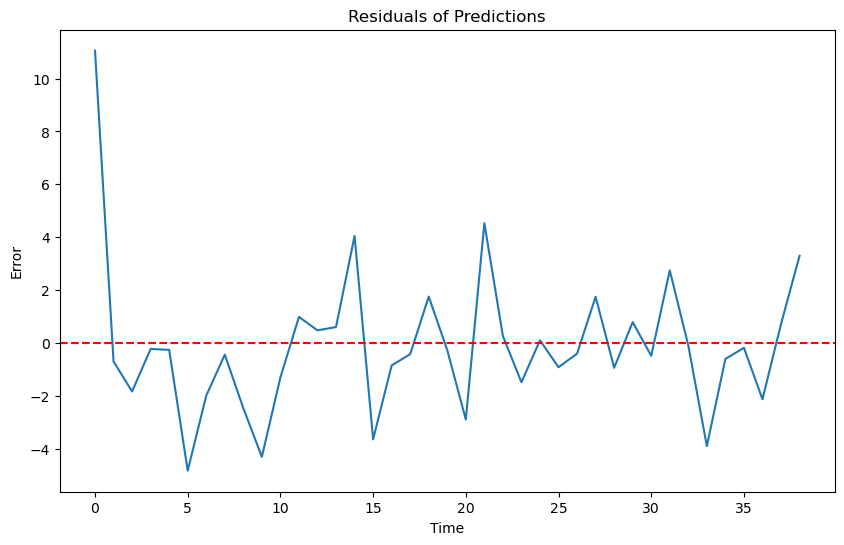

In [57]:
residuals2 = y_test_original2 - predicted_prices2

plt.figure(figsize=(10,6))
plt.plot(residuals2)
plt.title('Residuals of Predictions')
plt.xlabel('Time')
plt.ylabel('Error')
plt.axhline(y=0, color='red', linestyle='--')
plt.show()


#### Joining TDM Studio Sentiment Analysis and GME Stock data

In [ ]:
df_TDM_daily.head()

In [ ]:
len(df_TDM_daily)

In [ ]:
df_stock.head()

In [ ]:
len(df_stock)

In [ ]:
df_merged1 = pd.merge(df_stock, df_TDM_daily, on='Date', how='left')
df_merged1.head()

In [ ]:
df_merged1.isnull().sum()

In [ ]:
df_merged1.columns

### Appendix A - AI Prompts and Responses

**If I have two date values for a start and end date, how would I get all of the values in between them? For example, if I have 2015-11-16 to 2015-11-22?

In [ ]:
# from datetime import datetime, timedelta

# # Start and end dates
# start_date = datetime.strptime("2015-11-16", "%Y-%m-%d")
# end_date = datetime.strptime("2015-11-22", "%Y-%m-%d")

# # Generate all dates between start and end date
# date_generated = [start_date + timedelta(days=x) for x in range(0, (end_date-start_date).days + 1)]

# # Convert to strings if needed
# date_strings = [date.strftime("%Y-%m-%d") for date in date_generated]

# date_strings